# Segmenter les clients d'un site d'e-commerce
Dans ce Notebook, nous réaliserons une segmentation des client pour l'entreprise [Olist](https://olist.com/pt-br/) afin de permettre à ses équipes de e-commerce de l'utilisez pour leurs campagnes de communication. Notre objectif sera de comprendre les différents types d'utilisateurs grâce à leur comportement et à leur données personnelles.  


![Olist](https://user.oc-static.com/upload/2019/02/24/15510251487267_Capture%20d%E2%80%99e%CC%81cran%202019-02-20%20a%CC%80%2017.37.38.png)  


Olist exploite un site de commerce électronique en ligne destiné aux vendeurs, qui met en relation les commerçants et leurs produits avec les principales places de marché du Brésil. Olist a été fondée en 2015 par Tiago Dalvi. La société a son siège à Curitiba, Parana, au Brésil. Le produit phare d'Olist, Olist Store, offre aux commerçants un moyen de gérer les annonces de produits, la logistique et les paiements de magasin. Il propose également "une expérience de vente unique" à travers des canaux tels que Mercado Livre, B2W et Via Varejo. Olist a attiré plus de 200 000 utilisateurs dans 180 pays. La société compte plus de 45 000 commerçants et détaillants parmi ses clients.

## Utilisation de méthodes non supervisées pour le regroupement des clients de profils similaires.

### Introduction :  


Dans un paysage numérique en constante évolution, la compréhension des diverses typologies de clients revêt une importance capitale pour les entreprises opérant dans le domaine de l'e-commerce.  


Notre étude vise à disséquer et à catégoriser les utilisateurs de la plateforme [Olist](https://olist.com/pt-br/) en fonction de leurs comportements et de leurs données personnelles. En analysant ces paramètres cruciaux, nous cherchons à élucider les tendances, motivations et préférences qui sous-tendent les interactions des clients, afin d'optimiser leur expérience sur le site [Olist](https://olist.com/pt-br/) et de maximiser la valeur qu'ils en tirent.  


Cette segmentation fine permettra d'adapter la stratégies de marketing de la plateforme, d'améliorer la personnalisation des offres et de cibler efficacement les campagnes, renforçant ainsi la satisfaction et la fidélité de leur clientèle. La présente étude offre une vue d'ensemble détaillée des différentes cohortes d'utilisateurs, apportant ainsi des insights fondamentaux pour l'orientation stratégique de leur plateforme e-commerce.

## Table des matières


#### [1.Présentation des données](#1.-Présentation-des-données)
#### [2.Nettoyage du Dataset](#2.-Nettoyage-du-Dataset)
#### - [A.Traitement des valeurs aberrantes](#A.-Traitement-des-valeurs-aberrantes)
#### - [B.Traitement des valeurs manquantes](#B.-Traitement-des-valeurs-manquantes)

#### [3.Analyse exploratoire du Dataset](#3.-Analyse-exploratoire-du-Dataset)
#### - [A.Analyse univariées](#A.-Analyse-univariées)
#### - [B.Analyse bivariées](#B.-Analyse-bivariées)
#### - [C.Analyse multivariées](#C.-Analyse-multivariées)

## 1. Présentation des données

## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [2]:
#manipulation des données
import numpy as np
import pandas as pd 

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes 
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Import du Dataset
Tout d’abord, nous pouvons lister tous les fichiers de données disponibles. Il y a au total 9 fichiers organisés comme suit :
![image](https://i.imgur.com/HRhd2Y0.png)

In [3]:
print(os.listdir("./archive/"))

['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'brazilian_states_csv.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']


Nous importons les fichiers dont les données nous serons utile pour l'étude de cluestering des individus.

In [4]:
olist_orders_dataset = pd.read_csv('./archive/olist_orders_dataset.csv', sep=',')#
olist_sellers_dataset = pd.read_csv('./archive/olist_sellers_dataset.csv', sep=',')#
product_category_name_translation = pd.read_csv('./archive/product_category_name_translation.csv', sep=',')
olist_order_items_dataset = pd.read_csv('./archive/olist_order_items_dataset.csv', sep=',')#
olist_customers_dataset = pd.read_csv('./archive/olist_customers_dataset.csv', sep=',')#
olist_geolocation_dataset = pd.read_csv('./archive/olist_geolocation_dataset.csv', sep=',')#
olist_order_payments_dataset = pd.read_csv('./archive/olist_order_payments_dataset.csv', sep=',')#
olist_order_reviews_dataset = pd.read_csv('./archive/olist_order_reviews_dataset.csv', sep=',')#
olist_products_dataset = pd.read_csv('./archive/olist_products_dataset.csv', sep=',')#

La clef `geolocation_zip_code_prefix` permettant de fusionner les dataframe possède différentes géolocalisation pour une même clef. Nous pouvons simplifier le travail de fusion des dataframe en attribuant à une clef une seule valeurs de localisation.

In [5]:
olist_geolocation_dataset = olist_geolocation_dataset.drop_duplicates(subset=['geolocation_zip_code_prefix'])
olist_geolocation_dataset

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
...,...,...,...,...,...
999774,99955,-28.107588,-52.144019,vila langaro,RS
999780,99970,-28.345143,-51.876926,ciriaco,RS
999786,99910,-27.863500,-52.084760,floriano peixoto,RS
999803,99920,-27.858716,-52.300403,erebango,RS


Nous fusionnons les différents Dataframe pour simplifier notre travail d'analyse des différents individus et de leurs caractéristiques.

In [6]:
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_order_payments_dataset, on='order_id', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_order_reviews_dataset, on='order_id', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_order_items_dataset, on='order_id', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_products_dataset, on='product_id', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_sellers_dataset, on='seller_id', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_geolocation_dataset, left_on='seller_zip_code_prefix',\
                                 right_on='geolocation_zip_code_prefix', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_customers_dataset, on='customer_id', how='left')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_geolocation_dataset, left_on='customer_zip_code_prefix',\
                                 right_on='geolocation_zip_code_prefix', how='left')

In [7]:
olist_orders_dataset = olist_orders_dataset.drop(columns=['geolocation_zip_code_prefix_x', 'geolocation_city_x', 'geolocation_state_x', \
                                                          'geolocation_zip_code_prefix_y', 'geolocation_state_y'])
pd.set_option('display.max_columns', None) #permet d'afficher toutes les colonnes

Nous passons également par étape de traduction pour simplifier notre compréhension des données.

In [8]:
olist_orders_dataset = pd.merge(olist_orders_dataset, product_category_name_translation, on='product_category_name' , how='left')
olist_orders_dataset = olist_orders_dataset.drop(columns=['product_category_name'])
olist_orders_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,-23.680114,-46.452454,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,sao paulo,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,-23.680114,-46.452454,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,sao paulo,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,-23.680114,-46.452454,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,sao paulo,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,-19.810119,-43.984727,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,-12.169860,-44.988369,barreiras,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,-21.362358,-48.232976,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,-16.746337,-48.514624,vianopolis,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f1

Pour permettre une bonne compréhension des variables qui caractérisent chaque individus il est important d'avoir une explication clair du sens de chaque variable :  

 - `order_id` : identifiant unique de la commande
 - `customer_id` : clef des commande identifiant un client chaque commande à un identifiant unique.
 - `order_status` : Référence au statut de la commande (livrée, expédiée, etc.).
 - `order_purchase_timestamp` : Affiche l'horodatage de l'achat.
 - `order_approved_at` : Affiche l'horodatage de l'approbation du paiement.
 - `order_delivered_carrier_date` : Affiche l'horodatage de publication de la commande. Quand il a été remis au partenaire logistique.
 - `order_delivered_customer_date` : Affiche la date réelle de livraison de la commande au client.
 - `order_estimated_delivery_date` : Affiche la date de livraison estimée qui a été informée au client au moment de l'achat.
 - `payment_sequential` : un client peut payer une commande avec plusieurs modes de paiement. S'il le fait, une séquence sera créée pour accueillir tous les paiements.
 - `payment_type` : mode de paiement choisi par le client.
 - `payment_installments` : nombre de versements choisi par le client.
 - `payment_value` : valeur transactionnelle.
 - `review_id` : identifiant d'avis
 - `review_score` : Note allant de 1 à 5 donnée par le client sur une enquête de satisfaction.
 - `review_comment_title` : Titre du commentaire issu de l'avis laissé par le client, en portugais.
 - `review_comment_message` : Message de commentaire de l'avis laissé par le client, en portugais.
 - `review_creation_date` : Indique la date à laquelle l'enquête de satisfaction a été envoyée au client.
 - `review_answer_timestamp` : Affiche l'horodatage des réponses à l'enquête de satisfaction.
 - `order_item_id` : numéro séquentiel identifiant le nombre d’articles inclus dans la même commande.
 - `product_id` :identifiant unique du produit
 - `seller_id` : identifiant unique du vendeur
 - `shipping_limit_date` : Affiche la date limite d'expédition du vendeur pour le traitement de la commande vers le partenaire logistique.
 - `price` : prix de l'article
 - `freight_value` : article valeur du fret article (si une commande contient plus d'un article, la valeur du fret est répartie entre les articles)
 - `product_name_lenght` : nombre de caractères extraits du nom du produit.
 - `product_description_lenght` : nombre de caractères extraits de la description du produit.
 - `product_photos_qty` : nombre de photos de produits publiées
 - `product_weight_g` : poids du produit mesuré en grammes.
 - `product_length_cm` : longueur du produit mesurée en centimètres.
 - `product_height_cm` : hauteur du produit mesurée en centimètres.
 - `product_width_cm` : largeur du produit mesurée en centimètres.
 - `seller_zip_code_prefix` : 5 premiers chiffres du code postal
 - `seller_city` : Nom de Ville
 - `seller_state` : État
 - `geolocation_lat_x` : latitude
 - `geolocation_lng_x` : longitude
 - `customer_unique_id` : identifiant unique d'un client.
 - `customer_zip_code_prefix` : cinq premiers chiffres du code postal du client
 - `customer_city` : nom de la ville du client
 - `customer_state` : état du client
 - `product_category_name_english` : catégorie du produit

Nous pouvons désormais passer à une première étape d'analyse de nos données. Nous transformons le nom du dataframe et affichons le type de valeurs de chaque caractéristique.

In [9]:
data = olist_orders_dataset.copy()
data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
product_name_len

Nous pouvons également étudier la distribution de chaque variable pour tenter de mettre en avant les valeurs aberrantes ou atypiques qui pourraient biaiser la généralisation de notre modèle de Machine Learning

In [10]:
data.describe()

,payment_sequential,payment_installments,payment_value,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat_x,geolocation_lng_x,customer_zip_code_prefix,geolocation_lat_y,geolocation_lng_y
count,119140.000000,119140.000000,119140.000000,118146.000000,118310.000000,118310.000000,118310.000000,116601.000000,116601.000000,116601.000000,118290.000000,118290.000000,118290.000000,118290.000000,118310.000000,118045.000000,118045.000000,119143.000000,118821.000000,118821.000000
mean,1.094737,2.941246,172.735135,4.015582,1.196543,120.646603,20.032387,48.767498,785.967822,2.205161,2112.250740,30.265145,16.619706,23.074799,24442.410413,-22.797849,-47.238603,35033.451298,-21.232200,-46.192403
std,0.730141,2.777848,267.776077,1.400436,0.699489,184.109691,15.836850,10.033540,652.584121,1.717452,3786.695111,16.189367,13.453584,11.749139,27573.004511,2.690420,2.341104,29823.198969,5.573494,4.051132
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,-36.605374,-67.809656,1003.000000,-36.605374,-72.666706
25%,1.000000,1.000000,60.850000,4.000000,1.000000,39.900000,13.080000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,-23.609026,-48.831547,11250.000000,-23.588898,-48.089559
50%,1.000000,2.000000,108.160000,5.000000,1.000000,74.900000,16.280000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,-23.422076,-46.755211,24240.000000,-22.929319,-46.631691
75%,1.000000,4.000000,189.240000,5.000000,1.000000,134.900000,21.180000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,27972.000000,-21.766477,-46.518082,58475.000000,-20.198222,-43.615464
max,29.000000,24.000000,13664.080000,5.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,-2.546079,-34.847856,99990.000000,42.184003,-8.577855


## 2. Nettoyage du Dataset

Nous pouvons remarquer plusieurs valeurs atypique parmis les individus, nous devons analyser ces valeurs pour s'assurer que ce ne sont pas des valeurs aberrantes qui n'ont rien à faire dans les données et que nous devrions alors corriger.

In [11]:
data[data['payment_value'] > 10000]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
15914,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1.0,credit_card,1.0,13664.08,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667.0,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
15915,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1.0,credit_card,1.0,13664.08,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,2.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667.0,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
15916,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1.0,credit_card,1.0,13664.08,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,3.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667.0,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
15917,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1.0,credit_card,1.0,13664.08,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,4.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667.0,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
15918,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1.0,credit_card,1.0,13664.08,211fa81a22870cc634265ea85b751e40,1.0,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,5.0,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667.0,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
15919,03caa2c082116e1

In [12]:
data.loc[114498]['review_comment_message']

'COMPREI 2, APENAS 1 FOI ENTREGUE. ESTOU NO AGUARDO.'

Il semblerait que malgré le montant exorbitant par rapport aux autres valeurs constatées soit bien correct et correspond à 8 achats d'un montant de 1680 et de 8 livraison de 28.01. Le client indique seulement ne pas avoir reçu sa commande.

In [13]:
data[data['product_weight_g'] > 20000]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
20,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,1.0,credit_card,10.0,1376.45,NaN,NaN,NaN,NaN,NaN,NaN,1.0,638bbb2a5e4f360b71f332ddfebfd672,c4af86330efa7a2620772227d2d670c9,2018-01-12 19:09:04,1299.00,77.45,38.0,143.0,2.0,20850.0,100.0,25.0,50.0,8840.0,mogi das cruzes,SP,-23.477093,-46.135384,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ,-22.878477,-43.315170,rio de janeiro,construction_tools_construction
483,da8be3bb62e9bf01e2e1a3bfd74ebd1a,3f083b9f62e687be8d84684c7d54c8db,delivered,2017-04-06 13:44:08,2017-04-06 13:55:17,2017-04-08 01:37:04,2017-05-08 10:52:06,2017-05-04 00:00:00,1.0,credit_card,10.0,2751.24,b26a755642556c1b115289ed08626435,1.0,NaN,ainda não recebi o produto acredito que não se...,2017-05-06 00:00:00,2017-05-08 12:34:10,1.0,cea7edf64d9e93fbf6b89cc3ba537cd9,a4b6b9b992b46e9ef863637af96e04bc,2017-04-12 13:55:17,2690.00,61.24,57.0,492.0,1.0,25000.0,40.0,40.0,40.0,88090.0,florianopolis,SC,-27.589021,-48.598946,1e7097be947ad5d0f7819bdc9d8d7d0e,24716,sao goncalo,RJ,-22.794517,-43.008270,são gonçalo,garden_tools
537,f30607daae66843552e00843c6de88ef,8e1769459d9b9a9989799f6c79a4a663,delivered,2018-02-21 13:18:37,2018-02-23 02:31:22,2018-03-05 23:44:55,2018-04-12 11:36:51,2018-03-27 00:00:00,1.0,boleto,1.0,695.99,6a11203d05f191b3e0af7363ca15f7b6,1.0,NaN,"Mais respeito ao consumidor, era para presente!!",2018-03-31 00:00:00,2018-03-31 10:46:50,1.0,aed75ad669fbebd5a385ac7cc2ae7573,17f51e7198701186712e53a39c564617,2018-03-12 02:31:06,550.00,145.99,42.0,427.0,1.0,30000.0,50.0,75.0,56.0,3908.0,sao paulo,SP,-23.583598,-46.507148,1b1819e5da72c7a8c26b2e46aeeac553,28380,natividade,RJ,-21.043982,-41.974086,natividade,health_beauty
945,dd6d0f11a9c3d2abdc91e95b9598b332,e6c386cfd321a1708aa60ff6b8f46449,delivered,2018-01-11 21:42:30,2018-01-13 19:30:09,2018-02-08 21:16:40,2018-02-21 21:26:15,2018-03-01 00:00:00,1.0,credit_card,5.0,1692.05,c4452fe20cad5d07e0ad9a2b25c2d27e,1.0,NaN,Devido a uma irresponsabilidade da empresa o p...,2018-02-22 00:00:00,2018-02-23 22:12:59,1.0,b4436da747c3a53ab07ac0e71de17dcd,cf8ab1616079e2793aa29d524df01bb1,2018-02-01 19:29:39,1599.00,93.05,42.0,696.0,1.0,24450.0,105.0,50.0,20.0,4088.0,sao paulo,SP,-23.603266,-46.658822,5bc4d654dc4eb95cbd977eafadb38383,47600,bom jesus da lapa,BA,-13.251813,-43.418556,bom jesus da lapa,sports_leisure
1189,444ebbf5602b5acdad22e0b4a9951bda,a94259e3111386ff1ae6f1c3712fe6fb,delivered,2017-11-29 11:24:18,2017-11-29 11:37:34,2017-12-02 00:28:58,2017-12-09 15:36:43,2017-12-20 00:00:00,1.0,credit_card,3.0,372.72,b0e2831ef40a26224341cd7bb2191497,1.0,NaN,Recebi o produto correto porém é muito fraco e...,2017-12-10 00:00:00,2017-12-11 11:17:29,1.0,0454c95c31d75e5f86c354896a3d9814,2528513dd95219a6013d4d05176e391a,2017-12-05 11:37:34,299.00,73.72,44.0,246.0,1.0,25000.0,98.0,14.0,40.0,6060.0,osasco,SP,-23.552457,-46.780126,f5cd72e7209640c294bad4d57f4f7772,70297,brasilia,DF,-15.832940,-47.916011,brasília,kitchen_dining_laundry_garden_furniture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Nous ne remarquons pas à proprement parler de valeurs aberrantes dans les données mais certaines peuvent sembler atypique. Cela s'explique par le fait que `Olist` vend une large variété de produits.

Nous pouvons désormais étudier les valeurs manquantes des données pour nous permettre de réaliser correctement notre étude.

<Axes: >

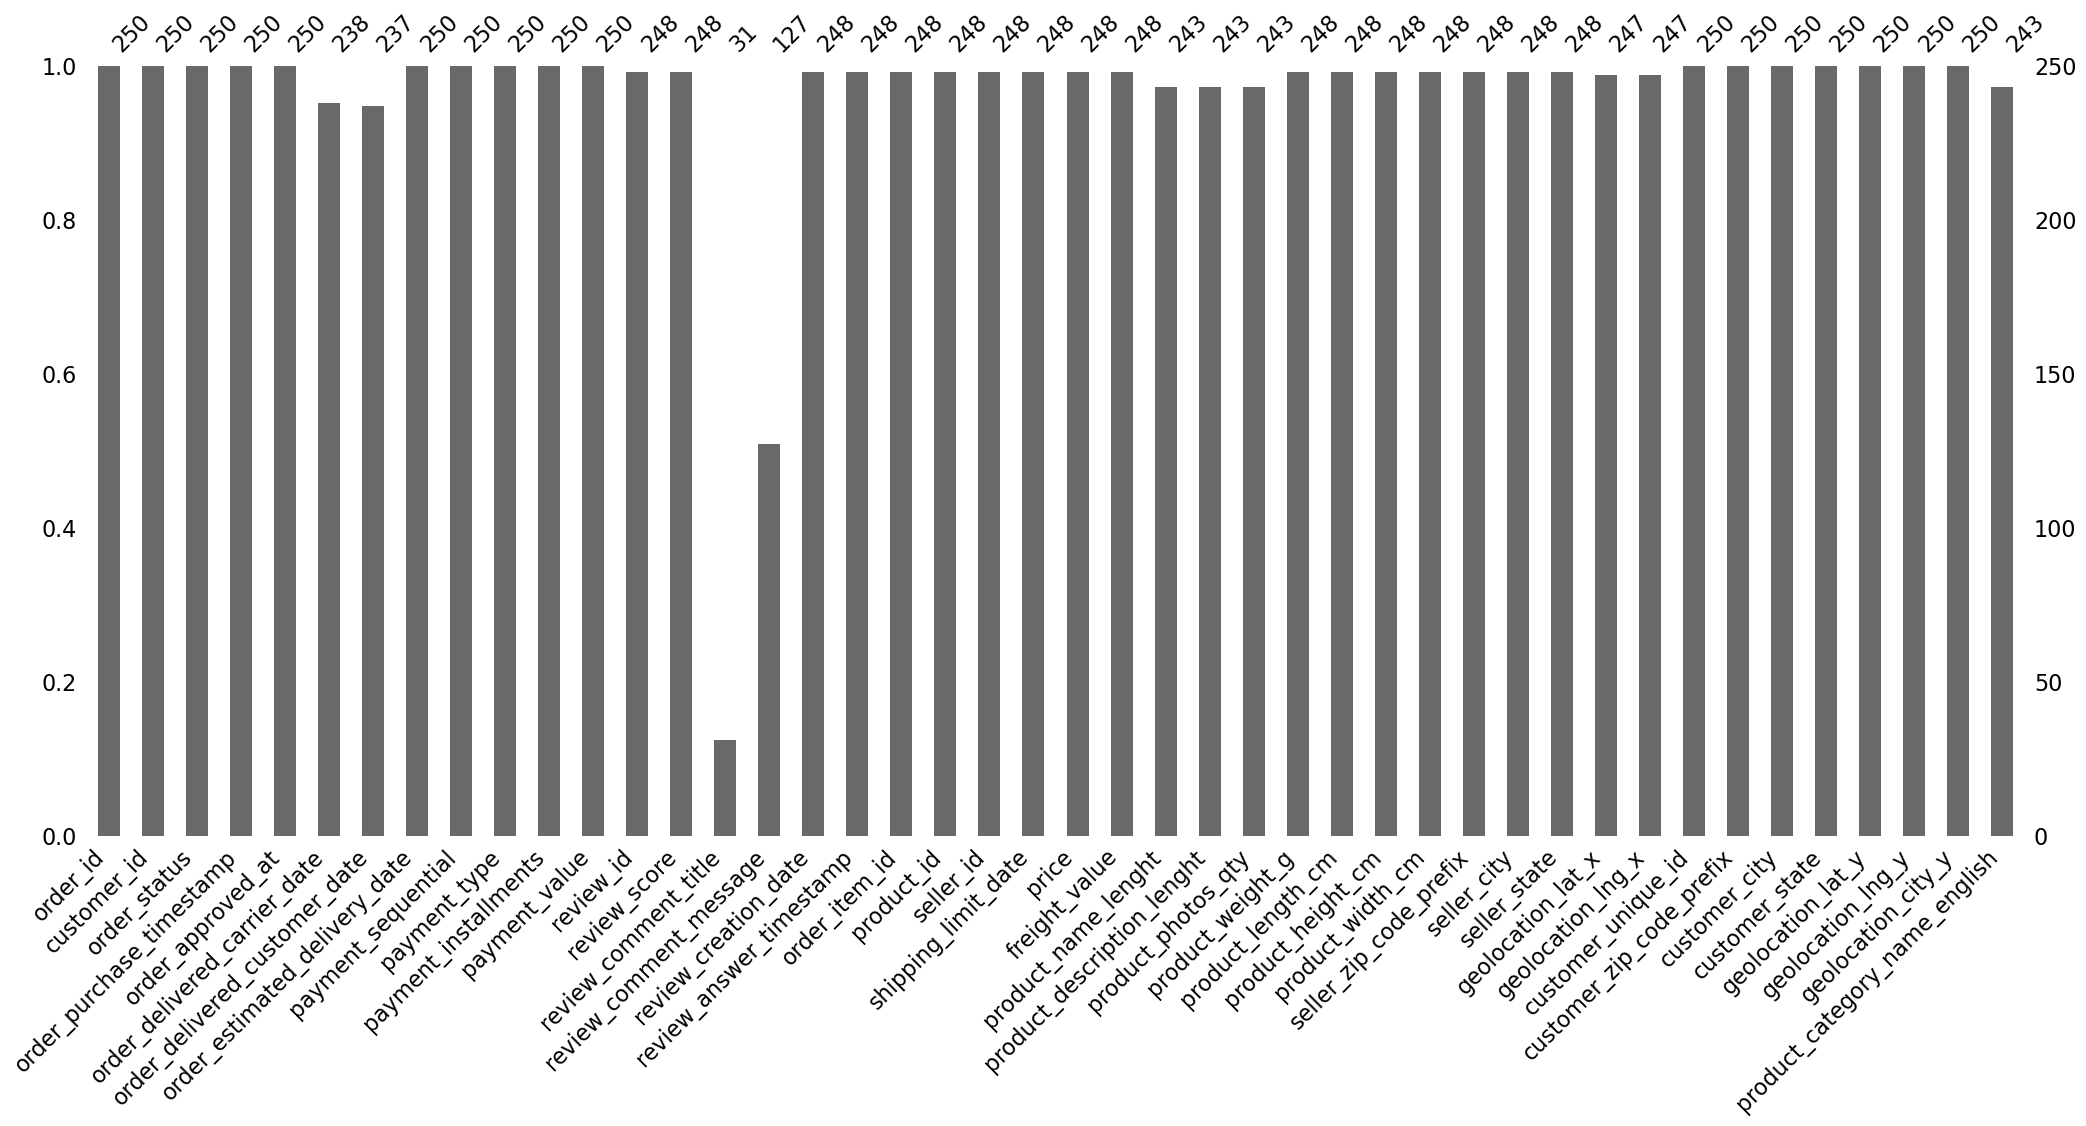

In [14]:
import missingno as msno
%matplotlib inline
msno.bar(data.sample(250))

Nous pouvons remarquer des valeurs manquantes dans `order_delivered_customer_date`, dans `order_delivered_delivered_date`, dans `review_comment_title` et dans `review_comment_message`. Les dates manquantes correspondent à des clients qui n'ont pas encore été livré ou qui dont le colis n'a pas encore donné au livreur, nous remplaçons ces valeurs manquantes par des valeurs neutre qui nous permettrons d'être correctement utilisé plus tard. Pour les 2 autres variables qui disposent de valeurs manquantes nous remplacerons ces valeurs par `no title` et `no comment` pour bien les identifier dans la suite de notre étude.

In [15]:
date_neutre_carrier = pd.to_datetime('1900-01-01 00:00:00')
date_neutre_customer = pd.to_datetime('1900-02-01 00:00:00')
data['order_delivered_carrier_date'] = data['order_delivered_carrier_date'].fillna(date_neutre_carrier)
data['order_delivered_customer_date'] = data['order_delivered_customer_date'].fillna(date_neutre_customer)

In [16]:
no_title = 'no title'
no_message = 'no message'
data['review_comment_title'] = data['review_comment_title'].fillna(no_title)
data['review_comment_message'] = data['review_comment_message'].fillna(no_message)

Nous pouvons également trouver des valeurs manquantes dans la caractéristique `order_approved_at`, c'est une information étrange mais pas primordiale, habituelement un achat doit être validé avant d'être envoyé, hors ce n'est pas le cas ici, nous remplaçons les valeurs manquantes par la date d'achat du client.

In [17]:
data[data['order_approved_at'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
1362,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-09-12 00:00:00,1.0,not_defined,1.0,0.00,9c0d840dfe562debfa52a1792bd64bff,1.0,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,NaN
2142,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-10-17 00:00:00,1.0,voucher,1.0,191.46,6e4344680dbd30c75f78394e0dcfffdf,2.0,no title,O produto veio com defeito ele não liga não fu...,2018-07-28 00:00:00,2018-07-30 11:06:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08642cd329066fe11ec63293f714f2f8,33030,santa luzia,MG,-19.784077,-43.929641,santa luzia,NaN
2232,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2017-04-10 00:00:00,1.0,boleto,1.0,139.96,d15ec7fbf73d246a918e3bf1a7e5f268,3.0,no title,Razoável,2017-04-12 00:00:00,2017-04-12 14:18:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c219f4ac1bc7f1aea33e6ab8885831e8,68742,castanhal,PA,-1.296150,-47.947770,castanhal,NaN
2429,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-09-13 00:00:00,1.0,voucher,1.0,66.44,0f54fea9e89c2a9398b2bd56e3880eda,5.0,Adorei,no message,2018-08-26 00:00:00,2018-08-26 20:21:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a8dd81392e5eee5d979c629a76abec2a,13059,campinas,SP,-22.946206,-47.135052,campinas,NaN
2586,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2017-05-30 00:00:00,1.0,credit_card,2.0,72.90,fda38b7c98f571ef4c6da9eba2b417c6,5.0,no title,no message,2017-06-01 00:00:00,2017-06-01 08:21:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29dc4aeff866d6a940c471a3ea4faef0,5752,sao paulo,SP,-23.618730,-46.750780,são paulo,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116985,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2017-07-25 00:00:00,1.0,credit_card,1.0,157.13,d01bf7ac62720a9f9b26a06400d48ae6,1.0,no title,Até agora não recebi nada até agora,2017-07-27 00:00:00,2017-07-27 07:42:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40d1c2a6b8ac6ccc102d473ff51cc46d,29156,cariacica,ES,-20.297537,-40.400869,cariacica,NaN
117882,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaN,1900-01-01 00:00:00,1900-02-01 00:00:00,2017-10-16 00:00:00,1.0,credit_card,1.0,280.20,c00b1a92c8643de86fef532ea9f244e9,1.0,no 

In [18]:
data['order_approved_at'].fillna(data['order_purchase_timestamp'], inplace=True)

Il semblerait qu'un achat ne possède pas de poids ni de taille, mais qu'il y a bien un montant pour l'envoi du colis. Ne s'agissant pas de la catégorie logiciel, le colis devait forcèment être physique, n'ayant pas suffisamment d'information pour remplacer les valeurs manquantes, il est préférable de supprimer l'individu afin de simplifier notre travail d'analyse.

In [19]:
data[data['product_weight_g'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
319,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,1900-01-01 00:00:00,1900-02-01 00:00:00,2017-12-05 00:00:00,1.0,credit_card,5.0,84.00,7fb04ba6e8b915c62557517d5c1e04ee,1.0,no title,Anunciam um produto que não tem em estoque e a...,2017-12-07 00:00:00,2017-12-11 10:37:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC,-26.227777,-49.415587,sao bento do sul,NaN
702,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-02-16 00:00:00,1.0,credit_card,1.0,97.68,b6ea5566d6060db04ebe53a1291e4541,3.0,no title,no message,2018-02-18 00:00:00,2018-02-20 19:23:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP,-24.011288,-46.418734,praia grande,NaN
828,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,1900-01-01 00:00:00,1900-02-01 00:00:00,2017-09-05 00:00:00,1.0,boleto,1.0,132.46,aaeb804fe1828db8cc3d8b52ec38a1fa,1.0,no title,Até hoje não recebi meu produto e nem uma resp...,2017-09-10 00:00:00,2017-09-12 17:00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP,-23.454905,-46.592706,sao paulo,NaN
887,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-02-06 00:00:00,1.0,boleto,1.0,134.38,519e62c42f33dce5b47ffddf9fde28df,1.0,no title,Não compre,2018-02-09 00:00:00,2018-02-09 03:22:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA,-9.387333,-38.223153,paulo afonso,NaN
1362,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,2018-08-28 15:26:39,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-09-12 00:00:00,1.0,not_defined,1.0,0.00,9c0d840dfe562debfa52a1792bd64bff,1.0,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,-23.527788,-46.660310,sao paulo,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118914,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,1900-01-01 00:00:00,1900-02-01 00:00:00,2018-02-06 00:00:00,1.0,boleto,1.0,210.09,396e26da77b10734f3f8b5d5515fef4e,1.0,no title,"UMA BOSTA NAO ENTREGA, E NAO FAZ ESTORNO DO VA...",2018-02-09 00:00:00,2018-02-09 10:12:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP,-23.483785,-46.541554,guarulhos,NaN
118946,3a3cddda5a7c27851bd96c3313412840,0b0d60

In [20]:
data['product_weight_g'].fillna(0, inplace=True)
data['payment_sequential'].fillna(0, inplace=True)
data['payment_type'].fillna(0, inplace=True)
data['payment_installments'].fillna(0, inplace=True)
data['payment_value'].fillna(0, inplace=True)
data['review_id'].fillna(0, inplace=True)
data['review_score'].fillna('no score', inplace=True)
data['review_answer_timestamp'].fillna(date_neutre_carrier, inplace=True)
data['review_creation_date'].fillna(date_neutre_carrier, inplace=True)
data['product_name_lenght'].fillna(0, inplace=True)
data['product_description_lenght'].fillna(0, inplace=True)
data['product_photos_qty'].fillna(0, inplace=True)

In [21]:
date_neutre_shipping = pd.to_datetime('1900-03-01 00:00:00')

data.loc[data['order_status'] == 'unavailable', 'order_item_id'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_id'] = 0
data.loc[data['order_status'] == 'unavailable', 'seller_id'] = 0
data.loc[data['order_status'] == 'unavailable', 'shipping_limit_date'] = date_neutre_shipping
data.loc[data['order_status'] == 'unavailable', 'price'] = 0
data.loc[data['order_status'] == 'unavailable', 'freight_value'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_name_lenght'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_description_lenght'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_photos_qty'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_weight_g'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_length_cm'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_height_cm'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_width_cm'] = 0
data.loc[data['order_status'] == 'unavailable', 'seller_zip_code_prefix'] = 0
data.loc[data['order_status'] == 'unavailable', 'seller_city'] = 'no city'
data.loc[data['order_status'] == 'unavailable', 'seller_state'] = 'no state'
data.loc[data['order_status'] == 'unavailable', 'geolocation_lat_x'] = 0
data.loc[data['order_status'] == 'unavailable', 'geolocation_lng_x'] = 0
data.loc[data['order_status'] == 'unavailable', 'product_category_name_english'] = 'no product'

In [22]:
data.loc[data['product_length_cm'].isna(), 'order_item_id'] = 0
data.loc[data['product_length_cm'].isna(), 'product_id'] = 0
data.loc[data['product_length_cm'].isna(), 'seller_id'] = 0
data.loc[data['product_length_cm'].isna(), 'shipping_limit_date'] = date_neutre_shipping
data.loc[data['product_length_cm'].isna(), 'freight_value'] = 0
data.loc[data['product_length_cm'].isna(), 'freight_value'] = 0
data.loc[data['product_length_cm'].isna(), 'product_length_cm'] = 0
data.loc[data['product_length_cm'].isna(), 'product_height_cm'] = 0
data.loc[data['product_length_cm'].isna(), 'product_width_cm'] = 0
data.loc[data['product_length_cm'].isna(), 'seller_zip_code_prefix'] = 0
data.loc[data['product_length_cm'].isna(), 'seller_city'] = 'no city'
data.loc[data['product_length_cm'].isna(), 'seller_state'] = 'no state'
data.loc[data['product_length_cm'].isna(), 'geolocation_lat_x'] = 0
data.loc[data['product_length_cm'].isna(), 'geolocation_lng_x'] = 0
data.loc[data['product_length_cm'].isna(), 'product_category_name_english'] = 'no product'

In [23]:
date_neutre_shipping = pd.to_datetime('1900-03-01 00:00:00')

data.loc[data['order_status'] == 'canceled', 'order_item_id'] = 0
data.loc[data['order_status'] == 'canceled', 'product_id'] = 0
data.loc[data['order_status'] == 'canceled', 'seller_id'] = 0
data.loc[data['order_status'] == 'canceled', 'shipping_limit_date'] = date_neutre_shipping
data.loc[data['order_status'] == 'canceled', 'price'] = 0
data.loc[data['order_status'] == 'canceled', 'freight_value'] = 0
data.loc[data['order_status'] == 'canceled', 'product_name_lenght'] = 0
data.loc[data['order_status'] == 'canceled', 'product_description_lenght'] = 0
data.loc[data['order_status'] == 'canceled', 'product_photos_qty'] = 0
data.loc[data['order_status'] == 'canceled', 'product_weight_g'] = 0
data.loc[data['order_status'] == 'canceled', 'product_length_cm'] = 0
data.loc[data['order_status'] == 'canceled', 'product_height_cm'] = 0
data.loc[data['order_status'] == 'canceled', 'product_width_cm'] = 0
data.loc[data['order_status'] == 'canceled', 'seller_zip_code_prefix'] = 0
data.loc[data['order_status'] == 'canceled', 'seller_city'] = 'no city'
data.loc[data['order_status'] == 'canceled', 'seller_state'] = 'no state'
data.loc[data['order_status'] == 'canceled', 'geolocation_lat_x'] = 0
data.loc[data['order_status'] == 'canceled', 'geolocation_lng_x'] = 0
data.loc[data['order_status'] == 'canceled', 'product_category_name_english'] = 'no product'

In [24]:
data['price'].fillna(0, inplace=True)
data['product_height_cm'].fillna(0, inplace=True)
data['product_width_cm'].fillna(0, inplace=True)
data['seller_zip_code_prefix'].fillna(0, inplace=True)
data['seller_city'].fillna('no city', inplace=True)
data['seller_state'].fillna('no state', inplace=True)
data['product_category_name_english'].fillna('no product', inplace=True)

In [25]:
data.loc[(data['geolocation_lat_x'].isna()) & (data['seller_city'] == 'brasilia'), 'geolocation_lat_x'] = -15.790439
data.loc[(data['geolocation_lng_x'].isna()) & (data['seller_city'] == 'brasilia'), 'geolocation_lng_x'] = -47.880655

data.loc[(data['geolocation_lat_x'].isna()) & (data['seller_city'] == 'sao paulo'), 'geolocation_lat_x'] = -23.545621
data.loc[(data['geolocation_lng_x'].isna()) & (data['seller_city'] == 'sao paulo'), 'geolocation_lng_x'] = -46.639292

data.loc[(data['geolocation_lat_x'].isna()) & (data['seller_city'] == 'pocos de caldas'), 'geolocation_lat_x'] = -21.791043
data.loc[(data['geolocation_lng_x'].isna()) & (data['seller_city'] == 'pocos de caldas'), 'geolocation_lng_x'] = -46.562444

data.loc[(data['geolocation_lat_x'].isna()) & (data['seller_city'] == 'curitiba'), 'geolocation_lat_x'] = -25.435488
data.loc[(data['geolocation_lng_x'].isna()) & (data['seller_city'] == 'curitiba'), 'geolocation_lng_x'] = -49.270214

data.loc[(data['geolocation_lat_x'].isna()) & (data['seller_city'] == 'porto alegre'), 'geolocation_lat_x'] = -30.032150
data.loc[(data['geolocation_lng_x'].isna()) & (data['seller_city'] == 'porto alegre'), 'geolocation_lng_x'] = -51.232552

data.loc[(data['geolocation_lat_x'].isna()) & (data['seller_city'] == 'aruja'), 'geolocation_lat_x'] = -23.398884
data.loc[(data['geolocation_lng_x'].isna()) & (data['seller_city'] == 'aruja'), 'geolocation_lng_x'] = -46.325267

In [26]:
data.loc[data['geolocation_lat_x'].isna(), 'geolocation_lat_x'] = 0
data.loc[data['geolocation_lng_x'].isna(), 'geolocation_lng_x'] = 0

In [27]:
data.drop(columns={'geolocation_city_y'}, inplace=True)

In [28]:
data[data['geolocation_lat_y'].isna()]
data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'PR'), 'geolocation_lat_y'] = -25.435488
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'PR'), 'geolocation_lng_y'] = -49.270214

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'DF'), 'geolocation_lat_y'] = -15.790439
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'DF'), 'geolocation_lng_y'] = -47.880655

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'RJ'), 'geolocation_lat_y'] = -22.902472
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'RJ'), 'geolocation_lng_y'] = -43.174059

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'PI'), 'geolocation_lat_y'] = -5.070946
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'PI'), 'geolocation_lng_y'] = -42.788482

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'GO'), 'geolocation_lat_y'] = -16.053463
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'GO'), 'geolocation_lng_y'] = -48.030561

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'PA'), 'geolocation_lat_y'] = -1.453384
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'PA'), 'geolocation_lng_y'] = -48.468106

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'RN'), 'geolocation_lat_y'] = -5.783671
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'RN'), 'geolocation_lng_y'] = -35.196947

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'CE'), 'geolocation_lat_y'] = -3.725240
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'CE'), 'geolocation_lng_y'] = -38.545775

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'SP'), 'geolocation_lat_y'] = -23.545621
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'SP'), 'geolocation_lng_y'] = -46.639292

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'BA'), 'geolocation_lat_y'] = -12.987172
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'BA'), 'geolocation_lng_y'] = -38.522682

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'RS'), 'geolocation_lat_y'] = -30.032150
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'RS'), 'geolocation_lng_y'] = -51.232552

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'RO'), 'geolocation_lat_y'] = -8.758144
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'RO'), 'geolocation_lng_y'] = -63.887973

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'MT'), 'geolocation_lat_y'] = -15.629664
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'MT'), 'geolocation_lng_y'] = -56.017254

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'ES'), 'geolocation_lat_y'] = -20.319586
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'ES'), 'geolocation_lng_y'] = -40.329319

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'MA'), 'geolocation_lat_y'] = -2.524427
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'MA'), 'geolocation_lng_y'] = -44.290479

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'PE'), 'geolocation_lat_y'] = -8.061695
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'PE'), 'geolocation_lng_y'] = -34.882393

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'MG'), 'geolocation_lat_y'] = -19.923989
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'MG'), 'geolocation_lng_y'] = -43.935706

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'AL'), 'geolocation_lat_y'] = -9.590207
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'AL'), 'geolocation_lng_y'] = -35.766997

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'PB'), 'geolocation_lat_y'] = -7.062455
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'PB'), 'geolocation_lng_y'] = -34.841780

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'TO'), 'geolocation_lat_y'] = -10.342336
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'TO'), 'geolocation_lng_y'] = -48.295596

data.loc[(data['geolocation_lat_y'].isna()) & (data['customer_state'] == 'SE'), 'geolocation_lat_y'] = -10.910515
data.loc[(data['geolocation_lng_y'].isna()) & (data['customer_state'] == 'SE'), 'geolocation_lng_y'] = -37.052401




In [29]:
Nan_values = data.isnull().sum()
total_values = len(data)
Nan_values = Nan_values[Nan_values > 0]
Nan_values_percentage = (Nan_values / total_values) * 100
Nan_values_percentage = round(Nan_values_percentage, 2)
print(Nan_values_percentage)

Series([], dtype: float64)


## 3. Analyse exploratoire du Dataset

Nous pouvons maintenant analyser les données, ces dernières concentrent 119.143 individus représentant 99.441 commandes, caractérisé par 43 variables. Ces commandes ont été réalisé par 96.096 clients et vendu par 3.054 vendeurs.

In [30]:
print(len(data['order_id'].unique()))
print(len(data['customer_unique_id'].unique()))#nombre de clients unique
print(len(data['seller_id'].unique())) # nombre de vendeurs unique

99441
96096
3054


Nous pouvons remarquer que 2.997 clients sont des clients récurrents de la plateforme et on effectué plusieurs achats, ce qui représente 3% de clients récurrents.

In [31]:
## FAUX il y a 3345 clients récurrents, corriger cette partie, c'est logique puisque nunique prend en compte les uniques de order et customer
clients_recurrents = data.groupby('customer_unique_id')['order_id'].nunique()
clients_recurrents = clients_recurrents[clients_recurrents > 1]
print(len(clients_recurrents))
print((len(clients_recurrents)/(len(data['customer_unique_id'].unique())))*100)

2997
3.1187562437562435


In [32]:
print(data['customer_unique_id'].value_counts()[data['customer_unique_id'].value_counts() > 1].shape)
print((13948/(len(data['customer_unique_id'].unique())))*100)

(14495,)
14.514652014652016


Nous pouvons également analyser le nombre de catégories de produits vendus sur la plateforme, elles sont au nombre de 71.

In [33]:
print(len(data['product_category_name_english'].unique()))

72


Nous pouvons par la suite effectuer une étude entre le nombre de clients/vendeurs par état le tout rapporté au nombre d'habitants dans ces états.

In [34]:
resultats = data.groupby('customer_state')['customer_unique_id'].unique()
customer_nb = []

for state, customer in resultats.items():
    customer_nb.append({'States' : state, 'Nombre_de_clients' : len(customer)})

df_clients = pd.DataFrame(customer_nb)

In [35]:
seller_filter = data.groupby('customer_state')['seller_id'].unique()
seller_nb = []

for state, seller in seller_filter.items():
    seller_nb.append({'States' : state, 'Nombre_de_vendeurs' : len(seller)})

df_brazilian_population = pd.read_csv('./archive/brazilian_states_csv.csv')

df_sellers = pd.DataFrame(seller_nb)
df_states = pd.merge(df_clients, df_sellers, on='States')
df_states = pd.merge(df_states, df_brazilian_population, on='States')
df_states

,States,Nombre_de_clients,Nombre_de_vendeurs,Population
0,AC,77,71,795145
1,AL,401,253,3327551
2,AM,143,119,3893763
3,AP,67,63,756500
4,BA,3277,966,15150143
5,CE,1313,527,8867448
6,DF,2075,783,2867869
7,ES,1964,735,3894899
8,GO,1952,720,6551322
9,MA,726,374,6861924


In [36]:
df_states['Ratio_vendeurs/clients'] = df_states['Nombre_de_vendeurs'] / df_states['Nombre_de_clients']
df_states['Ratio_clients/population'] = df_states['Nombre_de_clients'] / df_states['Population']
df_states['Ratio_vendeurs/population'] = df_states['Nombre_de_vendeurs'] / df_states['Population']

In [37]:
df_states

,States,Nombre_de_clients,Nombre_de_vendeurs,Population,Ratio_vendeurs/clients,Ratio_clients/population,Ratio_vendeurs/population
0,AC,77,71,795145,0.922078,0.000097,0.000089
1,AL,401,253,3327551,0.630923,0.000121,0.000076
2,AM,143,119,3893763,0.832168,0.000037,0.000031
3,AP,67,63,756500,0.940299,0.000089,0.000083
4,BA,3277,966,15150143,0.294782,0.000216,0.000064
5,CE,1313,527,8867448,0.401371,0.000148,0.000059
6,DF,2075,783,2867869,0.377349,0.000724,0.000273
7,ES,1964,735,3894899,0.374236,0.000504,0.000189
8,GO,1952,720,6551322,0.368852,0.000298,0.000110
9,MA,726,374,6861924,0.515152,0.000106,0.000055


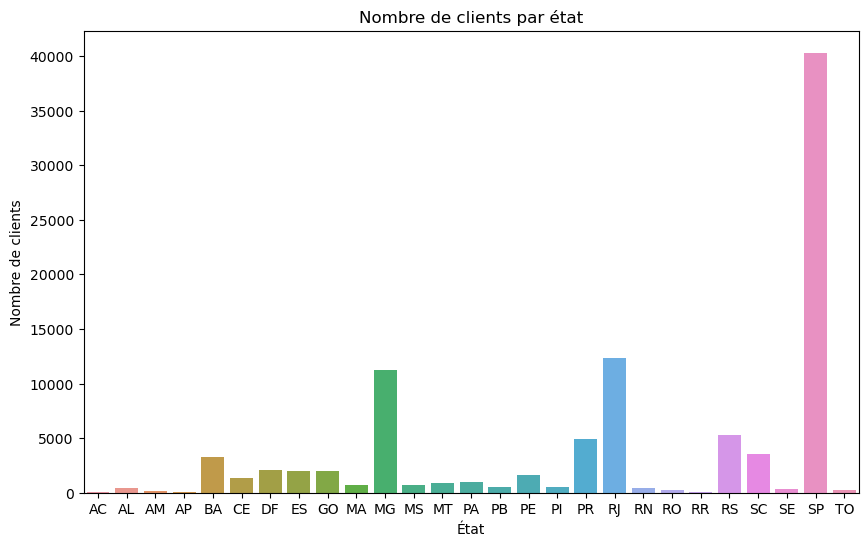

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='States', y='Nombre_de_clients', data=df_states)

plt.title('Nombre de clients par état')
plt.xlabel('État')
plt.ylabel('Nombre de clients')

plt.show()

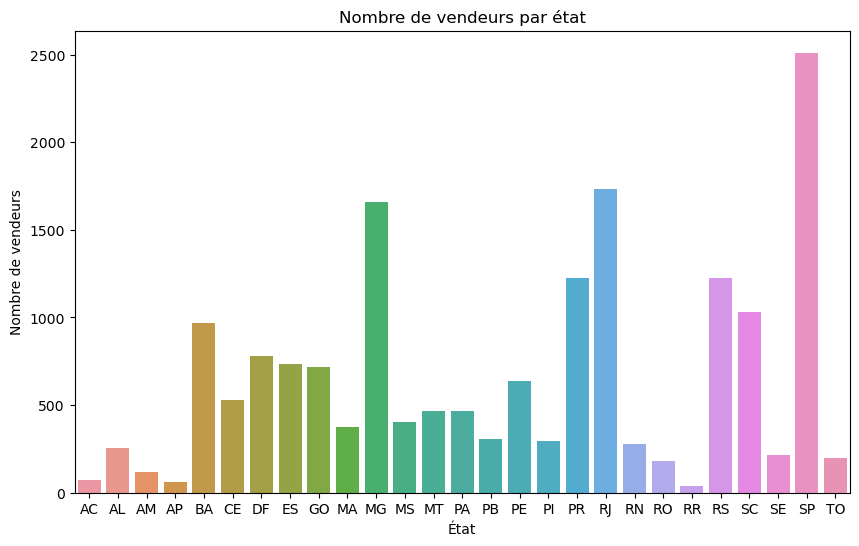

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='States', y='Nombre_de_vendeurs', data=df_states)

plt.title('Nombre de vendeurs par état')
plt.xlabel('État')
plt.ylabel('Nombre de vendeurs')

plt.show()

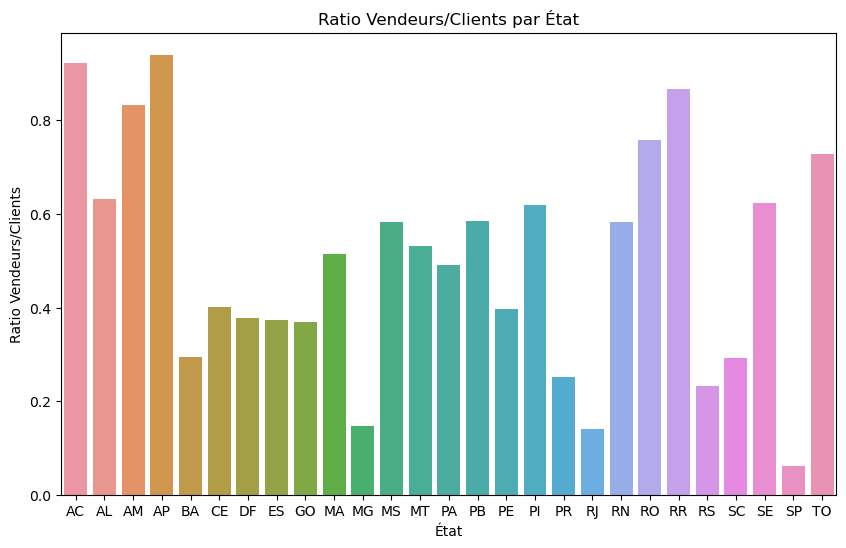

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='States', y='Ratio_vendeurs/clients', data=df_states)

plt.title('Ratio Vendeurs/Clients par État')
plt.xlabel('État')
plt.ylabel('Ratio Vendeurs/Clients')

plt.show()

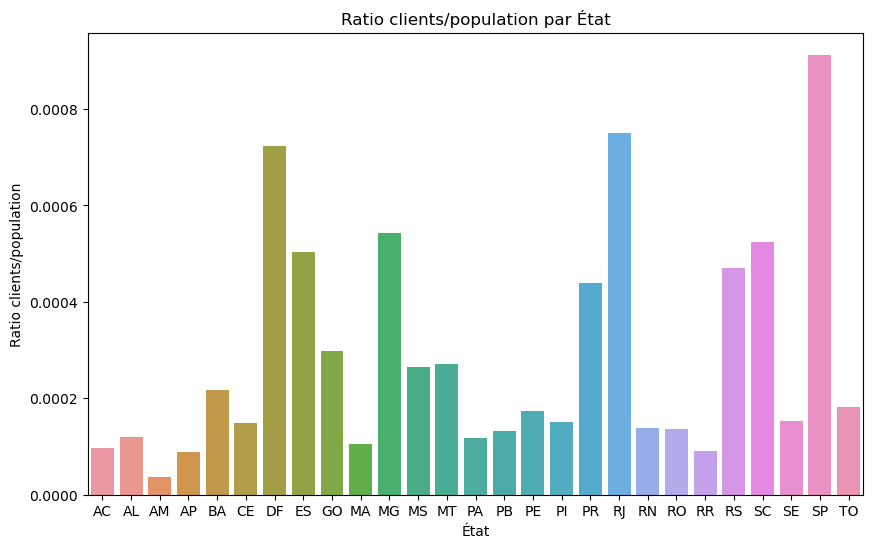

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='States', y='Ratio_clients/population', data=df_states)

plt.title('Ratio clients/population par État')
plt.xlabel('État')
plt.ylabel('Ratio clients/population')

plt.show()

Nous pouvons ensuite étudier la distribution du montant payé par les clients de la plateforme.

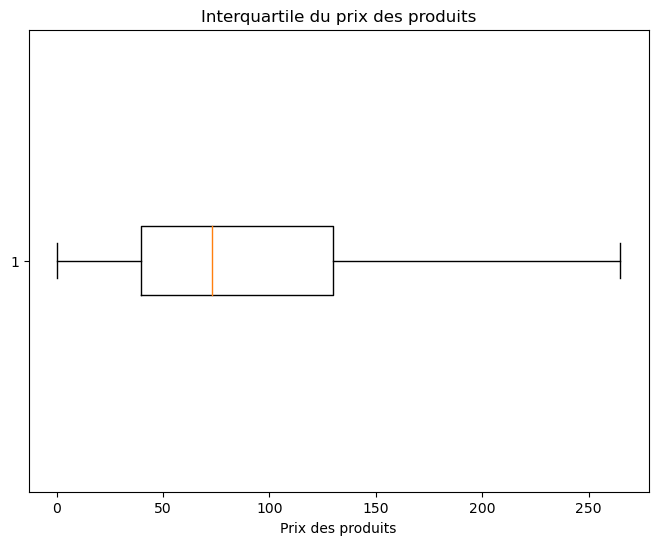

In [42]:
import matplotlib.pyplot as plt
data_amount = pd.DataFrame(data['price'])

plt.figure(figsize=(8, 6))
plt.boxplot(data_amount.values, vert=False, showfliers=False)
plt.xlabel('Prix des produits')
plt.title('Interquartile du prix des produits')

plt.show()

Nous pouvons ensuite étudier la distribution du prix d'envoi des produits.

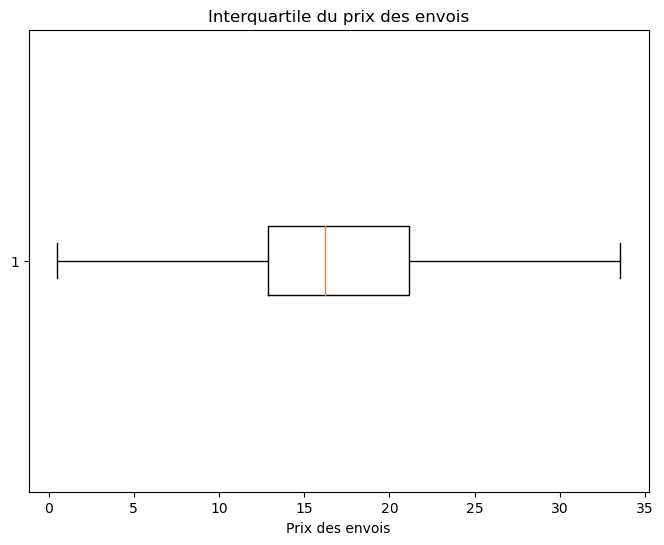

In [43]:
import matplotlib.pyplot as plt
data_freight = pd.DataFrame(data['freight_value'])

plt.figure(figsize=(8, 6))
plt.boxplot(data_freight.values, vert=False, showfliers=False)
plt.xlabel('Prix des envois')
plt.title('Interquartile du prix des envois')

plt.show()

Nous pouvons étudier le prix du frête en le comparant au volume du colis envoyé.

In [44]:
df_volume = []
df_volume = pd.DataFrame(df_volume)
df_volume['Volume_m3'] = (data['product_length_cm']/100)*(data['product_height_cm']/100)*(data['product_width_cm']/100)
df_volume['freight_value'] = data['freight_value']
df_volume

,Volume_m3,freight_value
0,0.001976,8.72
1,0.001976,8.72
2,0.001976,8.72
3,0.004693,22.76
4,0.009576,19.22
...,...,...
119138,0.016000,20.10
119139,0.063360,65.02
119140,0.008000,40.59
119141,0.008000,40.59


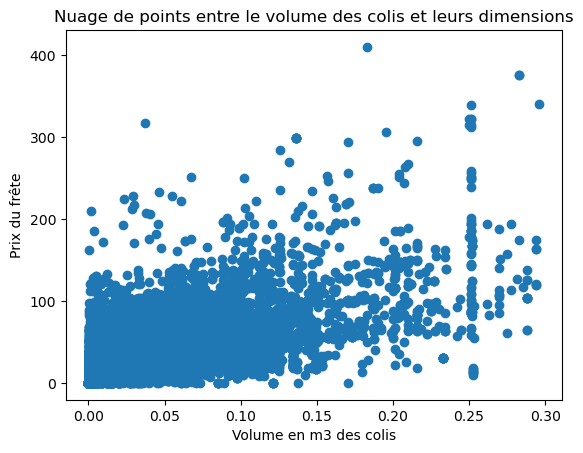

In [45]:
plt.scatter(df_volume['Volume_m3'], df_volume['freight_value'])

plt.xlabel('Volume en m3 des colis')
plt.ylabel('Prix du frête')
plt.title('Nuage de points entre le volume des colis et leurs dimensions')

plt.show()

In [46]:
import math

df_distance = []
df_distance = pd.DataFrame(df_distance)

def haversine(lat1, lon1, lat2, lon2):
    # Convertir les coordonnées degrés en radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Différence de latitude et de longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Formule de la haversine
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    # Rayon moyen de la Terre en kilomètres
    R = 6371.0

    # Calcul de la distance
    distance = R * c

    return distance

df_distance['Distance_km'] = data.apply(lambda row: haversine(row['geolocation_lat_x'], row['geolocation_lng_x'], row['geolocation_lat_y'], row['geolocation_lng_y']), axis=1)
df_distance['Price_freight'] = data['freight_value']
df_distance['Délais_jours'] = (pd.to_datetime(data['order_delivered_customer_date']) - pd.to_datetime(data['order_approved_at'])).dt.days
df_distance['Délais_estimé'] = (pd.to_datetime(data['order_estimated_delivery_date']) - pd.to_datetime(data['order_approved_at'])).dt.days
df_distance


,Distance_km,Price_freight,Délais_jours,Délais_estimé
0,18.063837,8.72,8,15
1,18.063837,8.72,8,15
2,18.063837,8.72,8,15
3,856.292580,22.76,12,17
4,514.130333,19.22,9,26
...,...,...,...,...
119138,474.098245,20.10,22,23
119139,968.051192,65.02,24,30
119140,370.146853,40.59,17,37
119141,370.146853,40.59,17,37


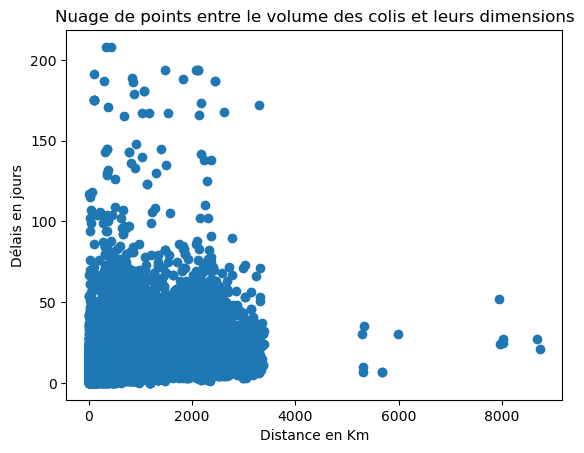

In [47]:
df_distance = df_distance[df_distance['Délais_jours'] >= 0]
plt.scatter(df_distance['Distance_km'], df_distance['Délais_jours'])

plt.xlabel('Distance en Km')
plt.ylabel('Délais en jours')
plt.title('Nuage de points entre le volume des colis et leurs dimensions')

plt.show()

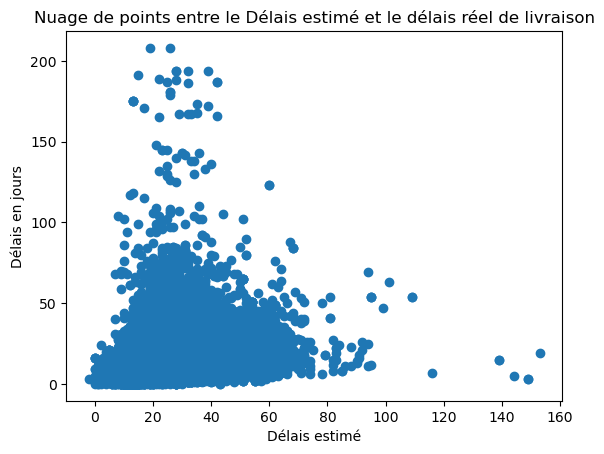

In [48]:
df_distance = df_distance[df_distance['Délais_jours'] >= 0]
plt.scatter(df_distance['Délais_estimé'], df_distance['Délais_jours'])

plt.xlabel('Délais estimé')
plt.ylabel('Délais en jours')
plt.title('Nuage de points entre le Délais estimé et le délais réel de livraison')

plt.show()

In [49]:
olist_dataset = 'olist_dataset.csv'
data.to_csv(olist_dataset, index=False)
